# Set Up

## Importing Libraries

In [233]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

## Extra

# Data Collection/Preprocessing

## Collecting Data

In [234]:
data = pd.read_csv("../outputs/training_metadata.csv")

In [235]:
data.head()

,path,left,right,forward,backward,brake
0,outputs/training_data/1.jpeg,1,0,1,0,0
1,outputs/training_data/2.jpeg,1,0,1,0,0
2,outputs/training_data/3.jpeg,1,0,1,0,0
3,outputs/training_data/4.jpeg,1,0,1,0,0
4,outputs/training_data/5.jpeg,0,1,1,0,0


## Analyzing Data

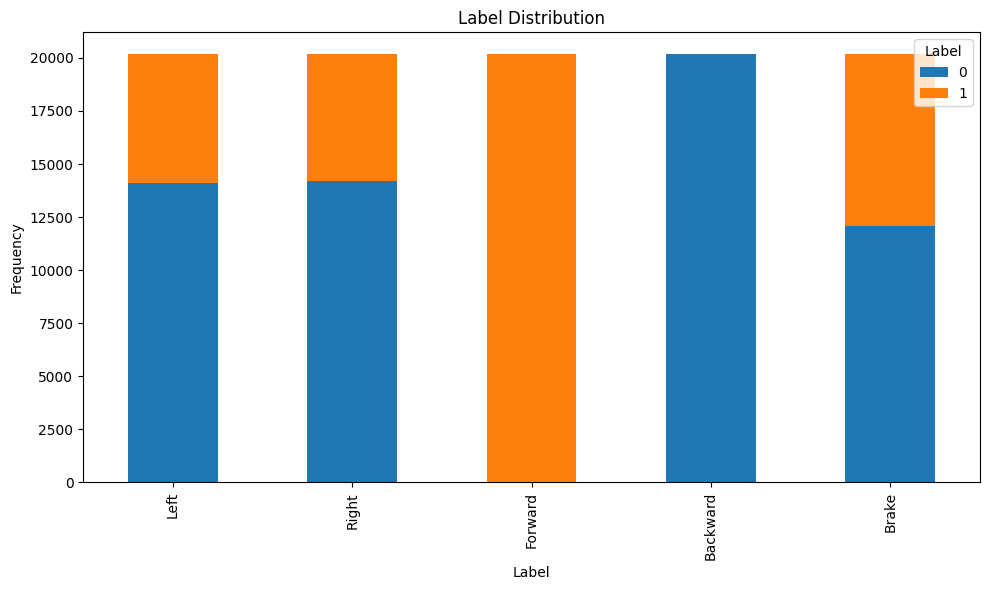

In [236]:
left_labels = data['left']
right_labels = data['right']
forward_labels = data['forward']
backward_labels = data['backward']
brake_labels = data['brake']

left_counts = left_labels.value_counts()
right_counts = right_labels.value_counts()
forward_counts = forward_labels.value_counts()
backward_counts = backward_labels.value_counts()
brake_counts = brake_labels.value_counts()

df = pd.DataFrame({
    'Left': left_counts,
    'Right': right_counts,
    'Forward': forward_counts,
    'Backward': backward_counts,
    'Brake': brake_counts
}).transpose()

# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.legend(['0', '1'], title='Label')

plt.tight_layout()
plt.show()

## Preprocessing Data

In [237]:
def load_image(image_path):
    image = Image.open("../"+image_path)
    image = np.array(image)
    return image

In [238]:
data['path'][0]

'outputs/training_data/1.jpeg'

In [239]:
images = [load_image(image_path) for image_path in data['path']]
images = np.array(images)

In [240]:
targets = data[['left', 'right', 'forward', 'brake']].values

## Splitting Data

In [241]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [242]:
len(X_train)

16156

In [243]:
len(X_test)

2020

In [244]:
sample_image_path = "../outputs/training_data/1.jpeg"
sample_image = Image.open(sample_image_path)
image_width, image_height = sample_image.size
num_channels = len(sample_image.getbands())

# Neural Network

## Model Set Up

In [245]:
optimizer = Adam(learning_rate=0.001)

In [246]:
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(
#         image_height, image_width, num_channels)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu',
#                   kernel_regularizer=regularizers.l2(0.0001)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu',
#                   kernel_regularizer=regularizers.l2(0.0001)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu',
#                  kernel_regularizer=regularizers.l2(0.0001)),
#     layers.Dropout(0.6),
#     layers.Dense(4, activation='sigmoid')
# ])

In [247]:
model = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(
        image_height, image_width, num_channels)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(40, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(4, activation='relu')
])

In [248]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 128)       3584      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 49, 49, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 32)        36896     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 16928)             0         
                                                                 
 dense_28 (Dense)            (None, 40)              

## Training Model

In [249]:
model.compile(optimizer=optimizer, loss='mse')

In [250]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
505/505 [==============================] - 93s 184ms/step - loss: 4.9535 - val_loss: 0.2301
Epoch 2/10
505/505 [==============================] - 94s 185ms/step - loss: 0.2269 - val_loss: 0.1546
Epoch 3/10
505/505 [==============================] - 85s 169ms/step - loss: 0.1846 - val_loss: 0.1434
Epoch 4/10
505/505 [==============================] - 95s 187ms/step - loss: 0.1635 - val_loss: 0.1374
Epoch 5/10
505/505 [==============================] - 90s 178ms/step - loss: 0.1525 - val_loss: 0.1358
Epoch 6/10
505/505 [==============================] - 89s 176ms/step - loss: 0.1436 - val_loss: 0.1347
Epoch 7/10
505/505 [==============================] - 89s 176ms/step - loss: 0.1395 - val_loss: 0.1238
Epoch 8/10
505/505 [==============================] - 92s 182ms/step - loss: 0.1339 - val_loss: 0.1275
Epoch 9/10
505/505 [==============================] - 90s 178ms/step - loss: 0.1331 - val_loss: 0.1321
Epoch 10/10
505/505 [==============================] - 95s 187ms/step - l

## Testing Model

In [251]:
test_loss = model.evaluate(X_test, y_test)

64/64 [==============================] - 3s 49ms/step - loss: 0.1326


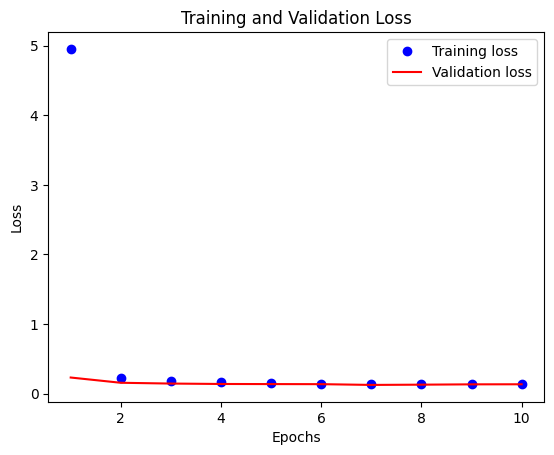

In [252]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

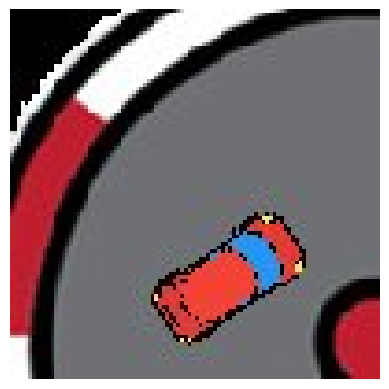

In [253]:
image = X_test[3]
plt.imshow(image)
plt.axis('off')
plt.show()

In [254]:
test_image = image.reshape(1, image_height, image_width, num_channels)
predictions = model.predict(test_image)
print(predictions)

1/1 [==============================] - 0s 38ms/step
[[0.32458675 0.33377874 1.0305846  0.37855667]]


## Prediction Distribution

In [255]:
predictions_list = []
for num in range(250):
    image = X_test[num]
    test_image = image.reshape(1, image_height, image_width, num_channels)
    prediction = model.predict(test_image)
    predictions_list.append(prediction)

1/1 [==============================] - 0s 13ms/step


In [256]:
predictions_list

[array([[0.23235896, 0.37877074, 0.9919808 , 0.3177153 ]], dtype=float32),
 array([[0.27569115, 0.26152638, 0.9903434 , 0.49090514]], dtype=float32),
 array([[0.       , 0.8587242, 1.0117126, 0.       ]], dtype=float32),
 array([[0.32458675, 0.33377874, 1.0305846 , 0.37855667]], dtype=float32),
 array([[0.18762429, 0.1469569 , 0.9990279 , 0.57700294]], dtype=float32),
 array([[0.14891112, 0.08802062, 1.0037504 , 0.6664309 ]], dtype=float32),
 array([[0.3938917 , 0.3021479 , 1.011673  , 0.22541654]], dtype=float32),
 array([[0.29583302, 0.29171368, 0.99685395, 0.44849473]], dtype=float32),
 array([[0.1738125 , 0.49375662, 1.0284097 , 0.05187795]], dtype=float32),
 array([[0.2769823 , 0.24186024, 1.0251684 , 0.44337425]], dtype=float32),
 array([[0.382986  , 0.40818176, 0.9527831 , 0.45610526]], dtype=float32),
 array([[0.2769823 , 0.24186024, 1.0251684 , 0.44337425]], dtype=float32),
 array([[0.51567984, 0.16395968, 0.9717105 , 0.        ]], dtype=float32),
 array([[0.22554056, 0.326472

In [257]:
for num in range(250):
    print(y_test[num])

[0 0 1 1]
[0 1 1 0]
[0 1 1 0]
[1 0 1 0]
[0 0 1 1]
[0 0 1 1]
[0 1 1 0]
[1 0 1 0]
[0 1 1 0]
[1 0 1 0]
[0 1 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 1]
[0 1 1 0]
[0 0 1 1]
[1 0 1 0]
[0 0 1 1]
[0 1 1 0]
[0 1 1 0]
[1 0 1 0]
[0 0 1 1]
[0 1 1 0]
[0 1 1 0]
[0 0 1 1]
[0 1 1 0]
[1 0 1 0]
[0 0 1 1]
[0 0 1 1]
[1 0 1 0]
[0 0 1 1]
[1 0 1 0]
[0 1 1 0]
[0 1 1 0]
[0 0 1 1]
[0 0 1 1]
[0 1 1 0]
[0 1 1 0]
[0 1 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 1]
[0 1 1 0]
[0 0 1 1]
[1 0 1 0]
[1 0 1 0]
[0 0 1 1]
[0 1 1 0]
[0 1 1 0]
[0 1 1 0]
[1 0 1 0]
[0 0 1 1]
[1 0 1 0]
[0 1 1 0]
[0 0 1 1]
[0 0 1 1]
[1 0 1 0]
[1 0 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 1]
[0 1 1 0]
[0 0 1 1]
[0 1 1 0]
[1 0 1 0]
[0 0 1 1]
[1 0 1 0]
[1 0 1 0]
[0 0 1 1]
[0 1 1 0]
[0 0 1 1]
[0 0 1 1]
[0 0 1 1]
[1 0 1 0]
[1 0 1 0]
[0 1 1 0]
[0 1 1 0]
[0 0 1 1]
[0 0 1 1]
[0 0 1 1]
[0 0 1 1]
[0 1 1 0]
[0 1 1 0]
[0 1 1 0]
[0 0 1 1]
[1 0 1 0]
[1 0 1 0]
[0 0 1 1]
[1 0 1 0]
[0 1 1 0]
[0 0 1 1]
[1 0 1 0]
[0 0 1 1]
[0 0 1 1]
[0 0 1 1]
[0 0 1 1]
[1 0 1 0]
[0 0 1 1]
[0 1 1 0]
[0 1 1 0]


## Saving Model Weights

In [258]:
model.save("../models/CNN_steering_model.h5")

/Users/andrew/Desktop/Projects/SelfDrivingCarSimulator/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
